# QSS20 Project 
Covid-19 twitter sentimate analysis

## Total sentimate analysis for states
Starting to look into specifics
Looking into state by state difference in overall negative / positive tweets

In [1]:
# All imports 

import re
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None # Stop the error messages

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from collections import defaultdict

import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')


from textblob import TextBlob
import emoji

# Set display option -- show the full text in the output
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


Loading tweets during COVID-19 from the twitter data set

In [2]:
# Load the data frame from the pickle file and display the first few rows
file_path = '/Users/alexwitheiler/Desktop/QSS20/project/covid_sample-0.001.pkl'
tweets = pd.read_pickle(file_path)

In [3]:
tweets.columns
tweets.head()

,tweetid,userid,screen_name,date,lang,location,place_id,place_url,place_type,place_name,place_full_name,place_country_code,place_country,place_bounding_box,text,extended,coord,reply_userid,reply_screen,reply_statusid,tweet_type,friends_count,listed_count,followers_count,favourites_count,statuses_count,verified,hashtag,urls_list,profile_pic_url,profile_banner_url,display_name,date_first_tweet,account_creation_date,rt_urls_list,mentionid,mentionsn,rt_screen,rt_userid,rt_text,rt_hashtag,rt_qtd_count,rt_rt_count,rt_reply_count,rt_fav_count,rt_tweetid,rt_location,qtd_screen,qtd_userid,qtd_text,qtd_hashtag,qtd_qtd_count,qtd_rt_count,qtd_reply_count,qtd_fav_count,qtd_tweetid,qtd_urls_list,qtd_location,sent_vader,token,media_urls,rt_media_urls,q_media_urls,state,country,rt_state,rt_country,qtd_state,qtd_country,norm_country,norm_rt_country,norm_qtd_country,description,rt_user_description,qtd_user_description,acc_age
15605,1220641644367765504,747463650881970176,gareth_grier,Fri Jan 24 09:37:01 +0000 2020,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"So, 40 new hospitals could be quicker than we think. Coronavirus outbreak: Hospital to be built in five days as dea… https://t.co/pjaRCXlyE0",no,NaN,NaN,NaN,NaN,original,1031,19.0,4114,5366,2625,False,[],"[{'url': 'https://t.co/pjaRCXlyE0', 'expanded_url': 'https://twitter.com/i/web/status/1220641644367765504', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}]",http://pbs.twimg.com/profile_images/1083866372579430407/JzkYY8KU_normal.jpg,https://pbs.twimg.com/profile_banners/747463650881970176/1496604690,Gareth grier,Fri Jan 24 09:37:01 +0000 2020,Mon Jun 27 16:16:36 +0000 2016,[],[],[],NaN,NaN,NaN,[],0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,[],0,0.0,0.0,0.0,NaN,[],NaN,0.0000,so 40 new hospitals could quicker think. coronavirus outbreak hospital built five days dea,[],[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16910,1220640235358281729,937270922234363905,Rose_ifnt,Fri Jan 24 09:31:25 +0000 2020,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT @WHO: Q: What is a #coronavirus? A: Coronaviruses are a large family of viruses that are known to cause illness ranging from the common…,no,NaN,NaN,NaN,NaN,retweeted_tweet_without_comment,80,1.0,58,90316,60775,False,['coronavirus'],[],http://pbs.twimg.com/profile_images/1119926824522223621/_ffKtTCP_normal.jpg,https://pbs.twimg.com/profile_banners/937270922234363905/1549894804,RosE_IFNT,Fri Jan 24 09:31:25 +0000 2020,Sun Dec 03 10:42:56 +0000 2017,"[{'url': 'https://t.co/sMsRFI1yNF', 'expanded_url': 'https://twitter.com/i/web/status/1218229883484155913', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [116, 139]}]",[14499829],['WHO'],WHO,1.449983e+07,Q: What is a #coronavirus? A: Coronaviruses are a large family of viruses that are known to cause illness ranging… https://t.co/sMsRFI1yNF,['coronavirus'],0,2500.0,0.0,2611.0,1.218230e+18,"Geneva, Switzerland",NaN,NaN,NaN,[],0,0.0,0.0,0.0,NaN,[],NaN,-0.4019,q what coronavirus a coronaviruses large family viruses known cause illness ranging,[],[],[],NaN,NaN,NaN,Switzerland,NaN,NaN,NaN,Switzerland,NaN,NaN,NaN,NaN,NaN
8796,1220632931489574913,3869545214,SinoVoices,Fri Jan 24 09:02:23 +0000 2020,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"RT @cnni: ""With the Wuhan coronavirus spreading across the country, killing at least 25 people so far, China is now facing a major test of…",no,NaN,NaN,NaN,NaN,retweeted_tweet_without_comment,950,0.0,117,3875,6403,False,[],[],http://pbs.twimg.com/profile_images/785615665377910784/4_E1SUHA_normal.jpg,https://pbs.twimg.com/profile_banners/3869545214/1573455445,Edwin Chen,Fri Jan 24 09:02:23 +0000 2020,Mon Oct 12 12:36:33 +0000 2015,"[{'url': 'https://t.co/QnMCcjXTr9', 'expanded_url': 'https://twitter.com/i/web/status/1220629988254322688', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [116, 139]}]",[2097571],['cnni'],cnni,2.097571e+06,"""With the Wuhan coronavirus spreading across the country, killing at least 25 people so far, China is now facing a…

Function for preprocessing tweets and text 

In [4]:
# Initialize the lemmatizer and tokenizer
# Break down the input text into individual tokens
lemmatizer = WordNetLemmatizer()
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)

# Set of stop words
stop_words = set(stopwords.words('english'))


def preprocess_text(text):
    # Replace emojis with text
    text = emoji.demojize(text, delimiters=(" ", " "))
    
    # Remove URLs, mentions, hashtags, punctuation, and numbers
    text = re.sub(r'http\S+|@\w+|#\w+|[^\w\s]', '', text)
    text = text.lower() # Lowercase text and expand contractions
    
    # Tokenize text, remove stop words, and lemmatize tokens
    tokens = tokenizer.tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word != 'rt']
    
    # Join tokens back to string
    return ' '.join(tokens)


Is that function efficent? Now, lets apply the function

In [5]:
# %%time 
# tweets.text.apply(lambda x: preprocess_text(str(x)))

In [6]:
tweets['cleaned_text'] = tweets['text'].apply(lambda x: preprocess_text(str(x)))


In [10]:
# Display the first few rows of the cleaned data
print(tweets[['text', 'cleaned_text']].head())


                                                                                                                                               text  \
15605  So, 40 new hospitals could be quicker than we think. Coronavirus outbreak: Hospital to be built in five days as dea… https://t.co/pjaRCXlyE0   
16910  RT @WHO: Q: What is a #coronavirus?  A: Coronaviruses are a large family of viruses that are known to cause illness ranging from the common…   
8796    RT @cnni: "With the Wuhan coronavirus spreading across the country, killing at least 25 people so far, China is now facing a major test of…   
14795                                                                             RT @siwuol_: rt to save life #coronavirus https://t.co/xQ8z2ihrAu   
4225   RT @people_paul: #uk #brexit #maga #Trump2020Landslide #conservatives @realDonaldTrump @BorisJohnson As reports come in that the Chinese au…   

                                                                                         clea

Sentiment Analysis

In [12]:
# Initialize the VADER sentiment analyzer
# Perform sentiment analysis
sia = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    return sia.polarity_scores(text)

# Apply sentiment analysis to the cleaned text string
tweets['sentiment'] = tweets['cleaned_text'].apply(lambda x: get_sentiment_score(x))

# Extract sentiment compound score for comparison
tweets['sentiment_score'] = tweets['sentiment'].apply(lambda x: x['compound'])


                                                                                                                                               text  \
15605  So, 40 new hospitals could be quicker than we think. Coronavirus outbreak: Hospital to be built in five days as dea… https://t.co/pjaRCXlyE0   
16910  RT @WHO: Q: What is a #coronavirus?  A: Coronaviruses are a large family of viruses that are known to cause illness ranging from the common…   
8796    RT @cnni: "With the Wuhan coronavirus spreading across the country, killing at least 25 people so far, China is now facing a major test of…   
14795                                                                             RT @siwuol_: rt to save life #coronavirus https://t.co/xQ8z2ihrAu   
4225   RT @people_paul: #uk #brexit #maga #Trump2020Landslide #conservatives @realDonaldTrump @BorisJohnson As reports come in that the Chinese au…   

                                                                                         clea

In [13]:
def determine_sentiment(score):
    # Determine sentiment based on compound score
    compound = score['compound']
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'
    
tweets['sentiment_label'] = tweets['sentiment'].apply(lambda x: determine_sentiment(x))

In [14]:
print(tweets[['text', 'cleaned_text', 'sentiment_score', 'sentiment_label']].head())

                                                                                                                                               text  \
15605  So, 40 new hospitals could be quicker than we think. Coronavirus outbreak: Hospital to be built in five days as dea… https://t.co/pjaRCXlyE0   
16910  RT @WHO: Q: What is a #coronavirus?  A: Coronaviruses are a large family of viruses that are known to cause illness ranging from the common…   
8796    RT @cnni: "With the Wuhan coronavirus spreading across the country, killing at least 25 people so far, China is now facing a major test of…   
14795                                                                             RT @siwuol_: rt to save life #coronavirus https://t.co/xQ8z2ihrAu   
4225   RT @people_paul: #uk #brexit #maga #Trump2020Landslide #conservatives @realDonaldTrump @BorisJohnson As reports come in that the Chinese au…   

                                                                                         clea

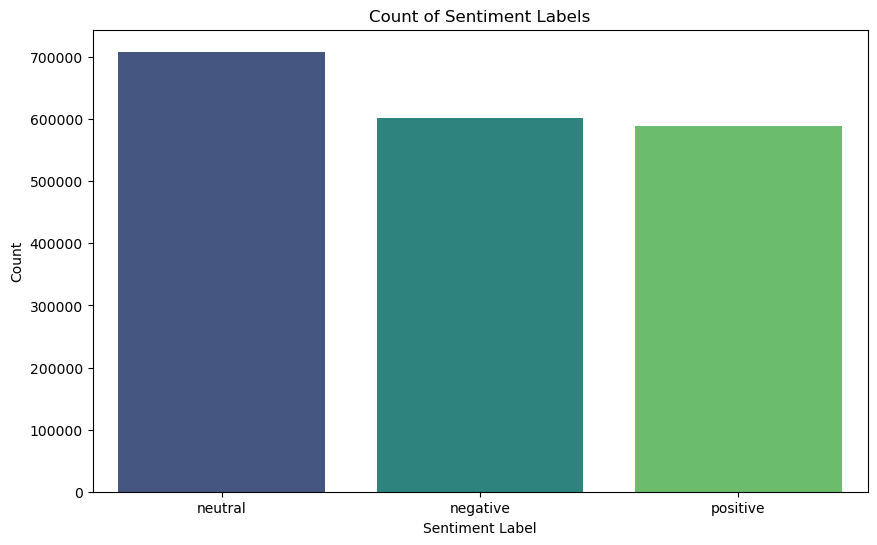

In [16]:
# Plot the count of sentiment labels
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment_label', data=tweets, palette='viridis')
plt.title('Count of Sentiment Labels')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()


Looking into US states

In [19]:
# Calculate average sentiment score by state
state_sentiment = tweets.groupby('state')['sentiment_score'].mean().reset_index()

# Display the first few rows
print(state_sentiment.head())

  state  sentiment_score
0    AK        -0.034781
1    AL        -0.014611
2    AR         0.003020
3    AZ        -0.030423
4    CA        -0.021769


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 [Text(0, 0, 'WY'),
  Text(1, 0, 'ID'),
  Text(2, 0, 'MT'),
  Text(3, 0, 'MN'),
  Text(4, 0, 'NM'),
  Text(5, 0, 'OK'),
  Text(6, 0, 'FL'),
  Text(7, 0, 'TN'),
  Text(8, 0, 'AK'),
  Text(9, 0, 'OR'),
  Text(10, 0, 'MS'),
  Text(11, 0, 'AZ'),
  Text(12, 0, 'CO'),
  Text(13, 0, 'DE'),
  Text(14, 0, 'MI'),
  Text(15, 0, 'LA'),
  Text(16, 0, 'MO'),
  Text(17, 0, 'WI'),
  Text(18, 0, 'CA'),
  Text(19, 0, 'UT'),
  Text(20, 0, 'OH'),
  Text(21, 0, 'SC'),
  Text(22, 0, 'ME'),
  Text(23, 0, 'IA'),
  Text(24, 0, 'TX'),
  Text(25, 0, 'SD'),
  Text(26, 0, 'WA'),
  Text(27, 0, 'HI'),
  Text(28, 0, 'NV'),
  Text(29, 0, 'CT'),
  Text(30, 0, 'NJ'),
  Text(31, 0, 'AL'),
  Text(32, 0, 'PA'),
  Text(33, 0, 'KY'),
  Text(34, 0, 'VA'),
  Text(35, 0, 'RI'),
  Text(36, 0, 'GA'),
  T

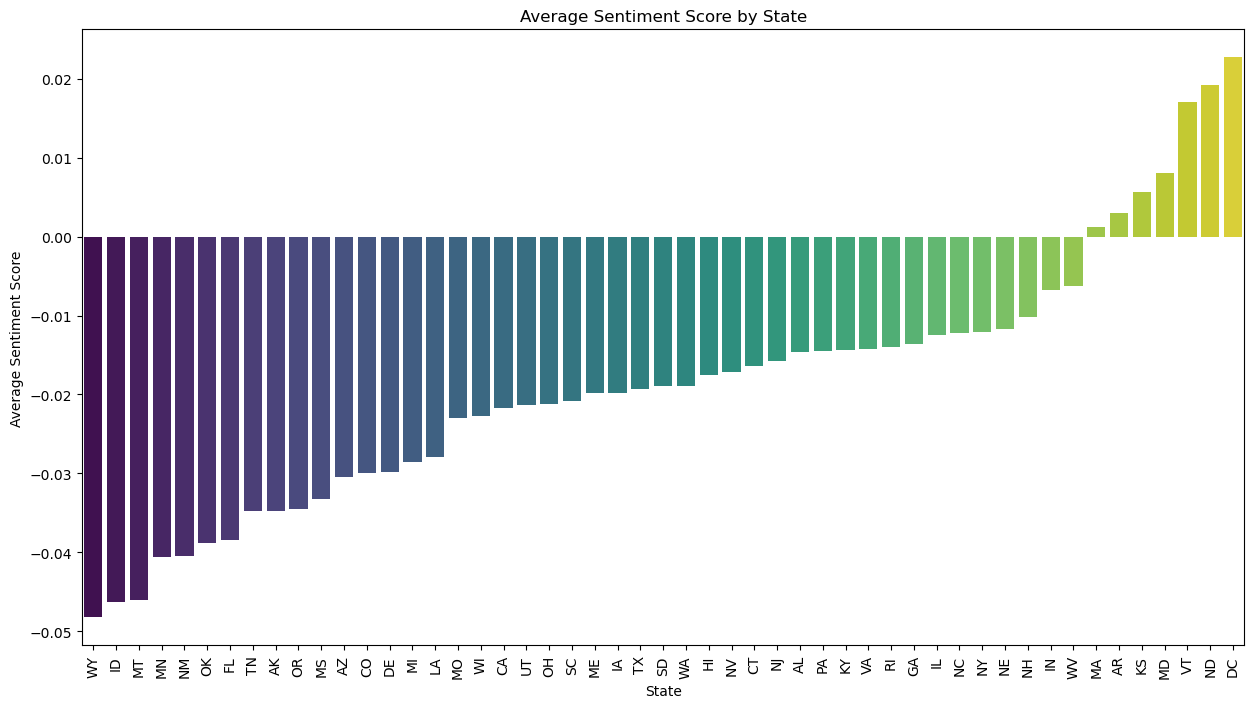

In [27]:
# Create Visualization
plt.figure(figsize=(15, 8))

# Sort the DataFrame by sentiment_score for aesthetic 
state_sentiment_sorted = state_sentiment.sort_values(by='sentiment_score', ascending=True)

# Create a bar plot for average sentiment score by state
sns.barplot(x='state', y='sentiment_score', data=state_sentiment_sorted, palette='viridis')

# Add titles and labels
plt.title('Average Sentiment Score by State')
plt.xlabel('State')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=90)  


In [44]:
# Define a function to get the most common negative words for a specific state
def get_most_common_negative_words(state, top_n=5):
    # Filter tweets for the specified state and with negative sentiment scores
    state_negative_tweets = tweets[(tweets['state'] == state) & (tweets['sentiment_score'] <= -0.5)]
    
    # Combine all cleaned texts of the state's negative tweets into one large string
    negative_text_combined = ' '.join(state_negative_tweets['cleaned_text'])
    
    # Split the combined text into tokens
    negative_tokens = negative_text_combined.split()
    
    # Count the frequency of each token
    token_counter = Counter(negative_tokens)
    
    # Get the most common tokens (e.g., top_n)
    most_common_tokens = token_counter.most_common(top_n)
    
    return most_common_tokens

In [45]:
# To get the most common negative words for all states, you can loop through unique states
all_states = tweets['state'].unique()
state_negative_words = {state: get_most_common_negative_words(state) for state in all_states}

# Print the most common negative words for each state
for state, words in state_negative_words.items():
    print(f"\nMost common negative words in {state}:")
    print(words)



Most common negative words in nan:
[]

Most common negative words in TX:
[('covid', 132), ('death', 98), ('collision', 63), ('people', 59), ('amp', 48)]

Most common negative words in MA:
[('covid', 34), ('death', 22), ('amp', 15), ('u', 11), ('people', 10)]

Most common negative words in FL:
[('covid', 141), ('death', 108), ('people', 43), ('american', 41), ('trump', 41)]

Most common negative words in DC:
[('covid', 44), ('death', 38), ('u', 27), ('day', 17), ('people', 17)]

Most common negative words in CA:
[('covid', 279), ('death', 207), ('people', 109), ('trump', 85), ('19', 77)]

Most common negative words in NC:
[('covid', 34), ('death', 28), ('people', 20), ('warning', 13), ('died', 13)]

Most common negative words in MD:
[('covid', 20), ('death', 15), ('people', 13), ('rocket', 11), ('trump', 10)]

Most common negative words in IL:
[('covid', 58), ('death', 43), ('people', 31), ('died', 29), ('american', 27)]

Most common negative words in CO:
[('covid', 41), ('death', 30),

In [ ]:
# State population data
state_populations = {
    'California': 39538223,      'Texas': 29145505,      'Florida': 21538187,    'New York': 20201249,
    'Pennsylvania': 13002700,    'Illinois': 12549689,   'Ohio': 11785935,    'Georgia': 11029227,
    'North Carolina': 10835491,  'Michigan': 10037261,   'New Jersey': 9290841,    'Virginia': 8715698,
    'Washington': 7812880,       'Arizona': 7431344,     'Tennessee': 7126489,    'Massachusetts': 7001399,
    'Indiana': 6862199,      'Missouri': 6196156,    'Maryland': 6180253,    'Wisconsin': 5910955,
    'Colorado': 5877610,    'Minnesota': 5737915,    'South Carolina': 5373555,    'Alabama': 5108468,
    'Louisiana': 4661468,    'Kentucky': 4505836,    'Oregon': 4318492,        'Oklahoma': 4000703,
    'Connecticut': 3605944,   'Utah': 3367281,        'Iowa': 3192406,            'Nevada': 3138259,
    'Arkansas': 3011524,    'Mississippi': 2961279,    'Kansas': 2937880,      'New Mexico': 2117522,
    'Nebraska': 1963331,    'West Virginia': 1781860,    'Idaho': 1839106,     'Hawaii': 1460137,
    'Maine': 1372247,       'New Hampshire': 1377529,    'Montana': 1103181,    'Rhode Island': 1110822,
    'Delaware': 1003384,    'South Dakota': 908414,    'North Dakota': 779094,    'Alaska': 733391,
    'Vermont': 643077,    'Wyoming': 576851
}

## Storage